### Torus Geometry
- **Triangular unit cell**: Primitive vectors |G₁|=|G₂| with 120 degree in between
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Bilayer Parameters
- **Nc_hopping = 2**: Number of layers (components)
- **Inter-layer distance**: d/l
- **Tunneling amplitude**: t/W0 (if t=0, should give the same result in example 3)
- **Displacement field**: ΔE/W0, energy difference between layers

### Interaction Details
- **Layer conservation**: Interactions preserve layer index of each particle
- **Layer symmetric**: Interactions unchanged if swap the two layer indices
- **Gate Screening**: D/l
- **Different-layer interaction**: Includes e^{-ql*d/l} attenuation factor
- **Form factor**: See arXiv.2509.07784 Eq.(A28) 

In [ ]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level torus.jl")
using .LLT

# square/triangular lattice
sqa_lattice = ReciprocalLattice(:square);          # == ReciprocalLattice(1, 0)
tri_lattice = ReciprocalLattice(:triangular);      # == ReciprocalLattice(1, -1//2)
# general_lattice = ReciprocalLattice(abs(G2/G1), cos(θ)), use exact value to avoid uncertainty on Brillouin Zone boundary.

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(subspaces)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
end

function plot_entanglement_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1,1];
        xlabel = "Ne in A-part",
        xticksvisible = false,
        xgridvisible = false,
        xminorgridvisible = true,
    )

    x = 0
    NA_lines = Float64[-0.5;]
    xtickposition = Float64[];
    xticklabel = String[];
    for indexNA in CartesianIndices(entanglement_spectrum)
        x_begin = x
        for (indexkA, spectrum) in enumerate(entanglement_spectrum[indexNA])
            if !isempty(spectrum)
                for e in spectrum
                    scatter!(ax, x, e, color = :blue, marker=:hline)
                end
                x += 1
            end
        end
        x_end = x
        if x_end > x_begin
            NA = string(indexNA[1]-1)
            for i in 2:length(indexNA)
                NA *= ",$(indexNA[i]-1)"
            end
            push!(xtickposition, 0.5(x_begin+x_end-1))
            push!(xticklabel, NA)
            push!(NA_lines, x+0.5)
        end
    end
    ax.xticks = (xtickposition, xticklabel)
    ax.xminorticks = NA_lines
    if title isa String
        ax.subtitle = title
    end
    ylims!(ax, ylims...)
    display(fig)
end

plot_ed_spectrum (generic function with 2 methods)

In [2]:
# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions

# Total number of electrons (3 electrons across both layers)
Ne = 6

# Number of layers (components) for bilayer system
Nc_hopping = 2

2

In [ ]:
t = 0.0 * LLT.W0               # Inter-layer tunneling strength
ΔE = 0 * LLT.W0                # Energy difference between the two layers

# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : hopping from component c2 to c1 at momentum k
# For bilayer system: Nc_hopping=2, Nc_conserve=1
H_onebody_bilayer = zeros(ComplexF64, Nc_hopping, Nc_hopping, 1, Nk)

# Add tunneling terms: t = 0.5 * W0 between different layers
# Tunneling conserves momentum (diagonal in k-space)
for k_idx in 1:Nk
    # Hopping
    H_onebody_bilayer[1, 2, 1, k_idx] = t
    H_onebody_bilayer[2, 1, 1, k_idx] = t
    # onsite energy difference
    H_onebody_bilayer[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer[2, 2, 1, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(tri_lattice,
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [4]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 0.5                  # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane
sys_int.V_intra = [0.0; 0.8; 0.0; 0.0]          # Intralayer Haldane pseudo-potential in unit of W0
sys_int.V_inter = [1.0; 0.0; 0.0; 0.0]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
# sys_int.V_intra = copy(intra_PP)
# sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_bilayer = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = Nc_hopping,
    Nc_conserve = 1,
    H_onebody = H_onebody_bilayer,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.634583819831362, 0.7492338495371395, 0.5285404117300112, 0.4186120084649848, 0.35021248081085243, 0.30257119442674524, 0.26703388875010214, 0.23927357356378345, 0.21685643443279629, 0.19829524059065834, 0.18262337867233533, 0.1691818697385912, 0.1575040036341515, 0.14724878200576702, 0.13816050881059833, 0.13004319773047726]
inter_PP = [1.227680253714756, 0.7105139963611995, 0.5157214926633534, 0.41202552162139605, 0.34609651899890626, 0.29971147973612533, 0.26491195947908125, 0.23762722611041615, 0.21553723586872509, 0.1972121254890013, 0.18171700561879395, 0.1684117139218252, 0.1568413327264065, 0.14667258987774875, 0.13765504023537262, 0.1295963774582997]


In [ ]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_k1, ss_k2 = ED_momentum_subspaces(para_bilayer, (Ne, ));
display(length.(subspaces))

# one-body and two-body terms in Hamiltonian
scat1 = ED_sortedScatterList_onebody(para_bilayer);
scat2 = ED_sortedScatterList_twobody(para_bilayer);

12-element Vector{Int64}:
 11202
 11196
 11196
 11240
 11232
 11232
 11202
 11196
 11196
 11240
 11232
 11232

In [6]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat2, scat1;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 11202, momentum 0, 0
  0.646117 seconds (693.03 k allocations: 149.119 MiB, 5.50% gc time, 182.50% compilation time)
  4.616267 seconds (5.62 M allocations: 503.812 MiB, 4.32% gc time, 76.38% compilation time)
Processing subspace #2 with size 11196, momentum 0, 1
  0.079051 seconds (11.76 k allocations: 113.996 MiB, 28.41% gc time)
  2.237059 seconds (19.89 k allocations: 319.434 MiB, 7.43% gc time)
Processing subspace #3 with size 11196, momentum 0, 2
  0.064574 seconds (11.76 k allocations: 113.996 MiB, 12.20% gc time)
  2.030944 seconds (20.61 k allocations: 334.882 MiB, 7.90% gc time)
Processing subspace #4 with size 11240, momentum 1, 0
  0.061847 seconds (11.81 k allocations: 114.477 MiB, 9.68% gc time)
  1.596967 seconds (15.24 k allocations: 242.080 MiB, 2.04% gc time)
Processing subspace #5 with size 11232, momentum 1, 1
  0.177127 seconds (11.85 k allocations: 114.380 MiB, 69.15% gc time)
  1.848501 seconds (15.85 k allocations: 247.427 MiB, 1

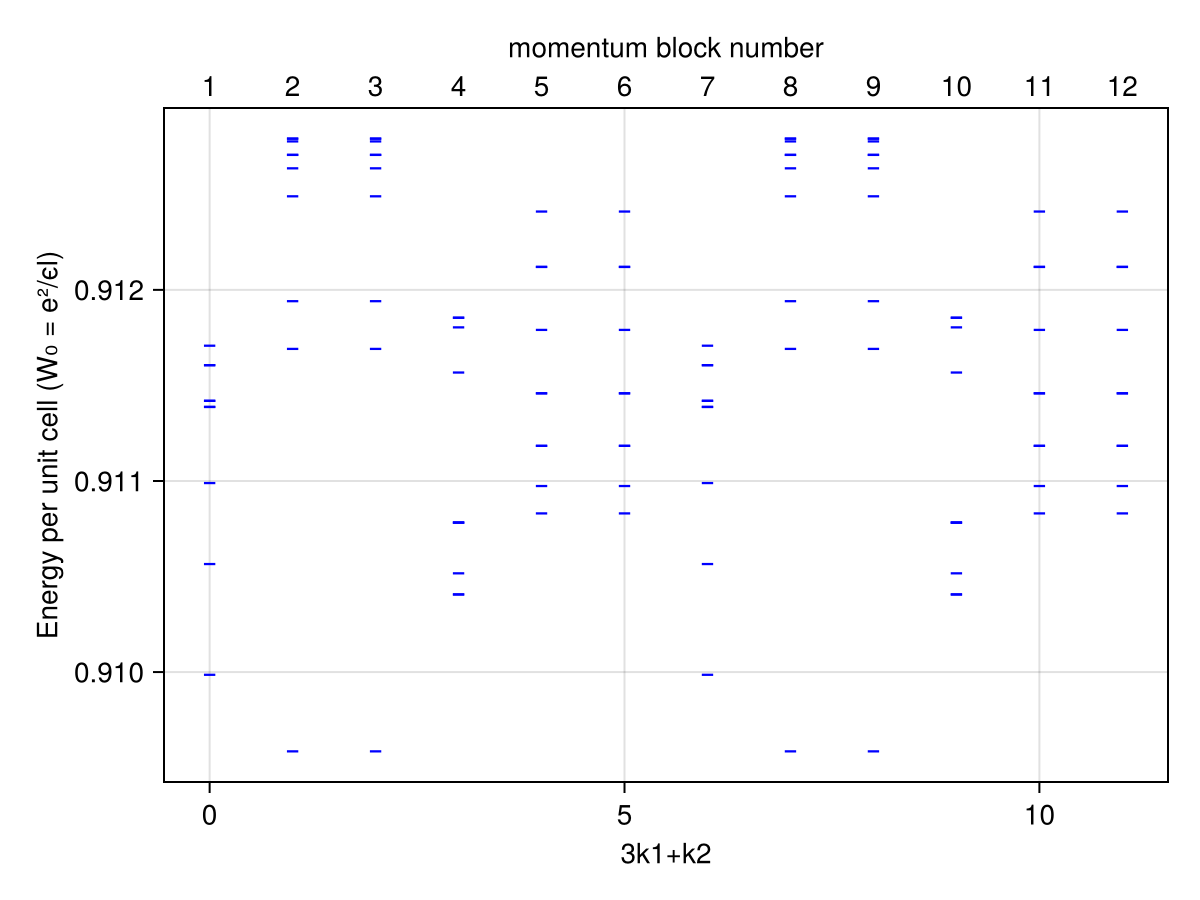

In [7]:
plot_ed_spectrum();

In [ ]:
# check energies explicitly to see degeneracy.

sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 0.9099857225616067
 0.9105652539699034
 0.9109890315497378
 0.9113874405560449
 0.9113874405560461
 0.9114194043104521
 0.9114194043104522
 0.9116059183050501
 0.9116059183050508
 0.9117078748288767

Compute and plot one-body reduced density matrix

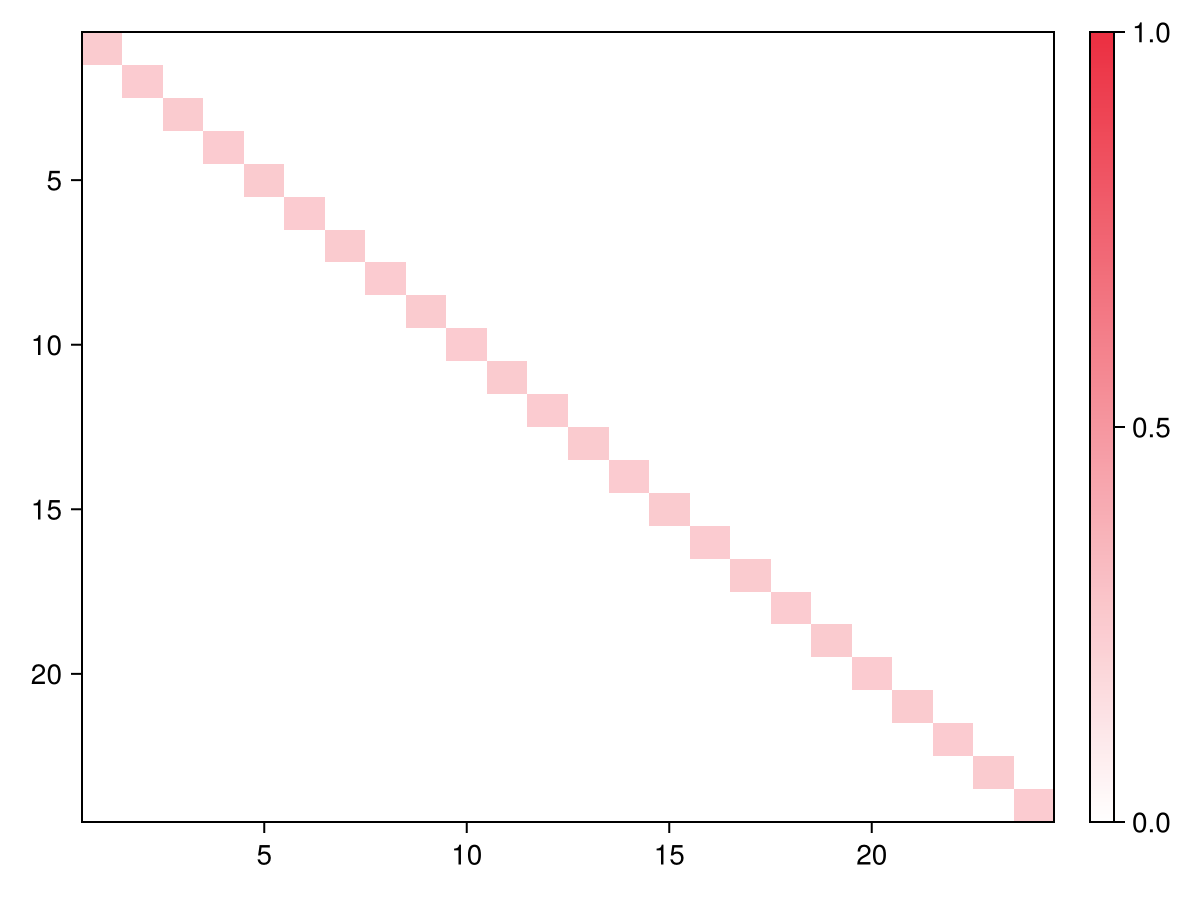

In [ ]:
# plot the reduced density matrix of the ground eigenstate in the first block
sn = 1
rdm = RDM_OneBody(vectors[sn][1])

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [10]:
# path for the Wilson loop integral on base manifold
# Landau level has uniform Berry curvature, so we compute Berry curvature of a small plaquate and then multiply plaquate number
N_shift = 8  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.125, 0.0)
 (0.125, 0.125)
 (0.0, 0.125)
 (0.0, 0.0)

In [ ]:
sn = 2                     # subspace number
nstates = 1                # number of degenerating states

psi_before = vectors[sn][1:nstates]
ED_connection_gaugefixing!(psi_before, collect(1000:1000+nstates-1))  # fix global phase

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    # One-body terms do not change when k are shifted
    scat_list2 = ED_sortedScatterList_twobody(para_bilayer; kshift = path[i+1]);
    psi_after = EDsolve(subspaces[sn], scat_list2, scat1; N = 6,
        showtime = false,
    )[2][1:nstates]
    ED_connection_gaugefixing!(psi_after, collect(1000:1000+nstates-1))  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step( 
        psi_after, psi_before, path[i+1], path[i], para_bilayer;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (0.125, 0.0)
Inner product: amp = 0.9999999999999991, phase = -0.130899693899494
path point #2 	 (0.125, 0.125)
Inner product: amp = 0.999999999999998, phase = 0.286343080405398
path point #3 	 (0.0, 0.125)
Inner product: amp = 1.0000000000000004, phase = 0.1554433865056639
path point #4 	 (0.0, 0.0)
Inner product: amp = 0.9999999999999976, phase = -0.26179938779928447


0.49999999999941874